In [1]:
import os
import sys

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt
from scipy.spatial import distance
from scipy.spatial import distance_matrix
import gudhi, gudhi.hera, gudhi.wasserstein, persim
import json

2023-01-28 07:27:27.316913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 07:27:27.551470: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/wsl/lib/libcuda.so.1:/opt/AMD/aocl/aocl-linux-aocc-3.1.0/lib:
2023-01-28 07:27:27.551495: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-28 07:27:28.376196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [ ]:
#import ripserplusplus as rpp

In [3]:
import plotly
from plotly.graph_objs import graph_objs as go
import ipywidgets as widgets
plotly.offline.init_notebook_mode(connected=True)
from plotly.offline import iplot

In [4]:
import mdtraj
from mdtraj import load

In [5]:
#os.chdir(r"C:\code\data\Micelles_identification")
#os.chdir("/mnt/c/code/data/Micelles_identification")
#os.chdir(r"Z:\data\micelles\Micelles_identification")
os.chdir("/mnt/z/data/micelles/Micelles_identification")

In [7]:
polyComp=os.listdir()
polyComp=[i for i in polyComp if i.find(".")==-1 and i!="High_conc"] #get rid of actionList if present -> do High_conc separately
polyComp

['L64', 'P104', 'P123', 'P65', 'P84', 'P85']

In [8]:
temps=[int(i)*10 for i in range(1,6)]
temps

[10, 20, 30, 40, 50]

# animSliderCode

In [36]:
def genAlphaSlider(dat,initial=.05,step=.25,maximum=20): #assume 3D for now
    ac = gudhi.AlphaComplex(dat)
    st = ac.create_simplex_tree()
    skel=list(st.get_skeleton(2))
    skel.sort(key=lambda s: s[1])
    points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
    lims=[[np.floor(np.min(dat[:,i])),np.ceil(np.max(dat[:,i]))] for i in range(3)]
    alpha = widgets.FloatSlider(
        value = initial,
        min = 0.0,
        max = maximum,
        step = step,
        description = 'Alpha:',
        readout_format = '.4f'
    )



    b1s=np.array([s[0] for s in skel if len(s[0]) == 2 and s[1] <= alpha.value])
    triangles = np.array([s[0] for s in skel if len(s[0]) == 3 and s[1] <= alpha.value])


    pts=go.Scatter3d(
        x = points[:, 0],
        y = points[:, 1],
        z = points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color="cornflowerblue",                # set color to an array/list of desired values
            #colorscale='Viridis',   # choose a colorscale
            opacity=.9
        ),
        name='H0'

    )

    sfig=[pts]

    linepts={0:[],1:[],2:[]}
    for i in b1s:
        linepts[0].append(points[i[0],0])
        linepts[1].append(points[i[0],1])
        linepts[2].append(points[i[0],2])
        linepts[0].append(points[i[1],0])
        linepts[1].append(points[i[1],1])
        linepts[2].append(points[i[1],2])

        linepts[0].append(None)
        linepts[1].append(None)
        linepts[2].append(None)

    if len(linepts[0])>0:
        lins=go.Scatter3d(
            x=linepts[0],
            y=linepts[1],
            z=linepts[2],
            mode='lines',
            name='H1',
            marker=dict(
                size=3,
                color="#d55e00",                # set color to an array/list of desired values
                #colorscale='Viridis',   # choose a colorscale
                opacity=.9
            )
        )
        sfig.append(lins)
        if len(triangles)>0:
            mesh = go.Mesh3d(
                x = points[:, 0],
                y = points[:, 1],
                z = points[:, 2],
                i = triangles[:, 0],
                j = triangles[:, 1],
                k = triangles[:, 2],
                color="#009e73",
                opacity=.75,
                name='H2'
            )


            sfig.append(mesh)
    fig=go.Figure(sfig)
    fig.update_layout(width=800,height=800)
    #fig.show()




    def view_SC(alpha):
        if alpha==0:
            fig=go.Figure(sfig[0])
            fig.show()
        else:
            b1s=np.array([s[0] for s in skel if len(s[0]) == 2 and s[1] <= alpha])

            linepts={0:[],1:[],2:[]}
            for i in b1s:
                linepts[0].append(points[i[0],0])
                linepts[1].append(points[i[0],1])
                linepts[2].append(points[i[0],2])
                linepts[0].append(points[i[1],0])
                linepts[1].append(points[i[1],1])
                linepts[2].append(points[i[1],2])

                linepts[0].append(None)
                linepts[1].append(None)
                linepts[2].append(None)

            if len(linepts[0])>0:
                lins=go.Scatter3d(
                    x=linepts[0],
                    y=linepts[1],
                    z=linepts[2],
                    mode='lines',
                    name='H1',
                    marker=dict(
                        size=3,
                        color="#d55e00",                # set color to an array/list of desired values
                        #colorscale='Viridis',   # choose a colorscale
                        opacity=.85
                    )
                )
                if len(sfig)>1:
                    sfig[1]=lins
                else:
                    sfig.append(lins)
                triangles = np.array([s[0] for s in skel if len(s[0]) == 3 and s[1] <= alpha])
                if len(triangles)>0:
                    mesh = go.Mesh3d(
                        x = points[:, 0],
                        y = points[:, 1],
                        z = points[:, 2],
                        i = triangles[:, 0],
                        j = triangles[:, 1],
                        k = triangles[:, 2],
                        color="#009e73",
                        opacity=.5,
                        name='H2'
                    )

                    if len(sfig)>1:
                        sfig[2]=mesh
                    else:
                        sfig.append(mesh)


            fig=go.Figure(data=sfig,layout=go.Layout(width=800,height=800,
                                                     title=f"Simplicial complex with radius <= {round(float(alpha),5)}",
                                                    ))

            #fig.show()
            iplot(fig)


    widgets.interact(view_SC, alpha = alpha);
    return st

In [ ]:

comp="P85"
temp=temps[0]
temp=30

groFile=mdtraj.load(f"{comp}/{comp}_{temp}.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)


dat=p0Gro.xyz[0,:] ##time 0



In [ ]:
polyComp

In [ ]:
#Load a testdat

#comp=polyComp[0]
comp="P85"
temp=temps[0]
temp=30

groFile=mdtraj.load(f"{comp}/{comp}_{temp}.gro")

p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)


dat=p0Gro.xyz[0,:]
nD=dat.shape[1]
ac = gudhi.AlphaComplex(dat)

st = ac.create_simplex_tree(max_alpha_square=np.sum([(np.max(dat)-np.min(dat))**2 for i in range(nD)]))
dgm = st.persistence()
skel=list(st.get_skeleton(2))
skel.sort(key=lambda s: s[1])
points = np.array([ac.get_point(i) for i in range(st.num_vertices())])


In [ ]:
skel[len(points):len(points)+5] # why is this showing the second value as much higher than box params??

In [ ]:
np.linalg.norm(points[443]-points[444])

In [ ]:
ac = gudhi.AlphaComplex(dat,precision="exact")
st = ac.create_simplex_tree()#max_alpha_square=np.sum([(np.max(dat)-np.min(dat))**2 for i in range(nD)]))
dgm = st.persistence()
skel=list(st.get_skeleton(2))
skel.sort(key=lambda s: s[1])
points = np.array([ac.get_point(i) for i in range(st.num_vertices())])

alpha=20

notInc=False
sub=[i for i in skel if 0<i[1]<alpha]
for j in range(1,len(sub)):
    prevNorm=np.linalg.norm(points[sub[j-1][0][1]]-points[sub[j-1][0][0]])
    if len(sub[j][0])==2: # just work with edges
        if np.linalg.norm(points[sub[j][0][1]]-points[sub[j][0][0]])<prevNorm:
            print(f"bad: {j} \t {sub[j][1]} \n{np.linalg.norm(points[sub[j][0][1]]-points[sub[j][0][0]])} \n{np.linalg.norm(points[sub[j][0][1]]-points[sub[j][0][0]])-prevNorm}\n\n")
            

In [ ]:
b0=[i[1] for i in dgm if i[0]==0]
b0.sort(key=lambda x: x[1]-x[0])
b0

Okay.. I don't know why the precision is so weird for the alpha complex, but we are shown equivalent monotonic behavior between the distances and the persistence numeric shown in the skeleton.  

## however, the error from th

In [ ]:
skelD[0][1]**2

In [ ]:
# with that in mind, let's just remap the sorted skeleton values to the ones we expect
# with meshes being generalized to max(dist(i,j))


#for Visual applications we want the regular distance matrix to make intuition,
    # except if we can color/show OutOfBound Simplices differently #todo
#however for numerical applications (ML) we want to probably show/use the
#periodic boundary distance matrix

def pDistIndex(pdist,i: int, j: int,length: int):
    if j<i:
        i,j = j,i
    if i==j:
        return 0
    
    return length*i+j-((i+2)*(i+1)) //2

dm=distance.pdist(points)
skelD=[(i[0],dm[pDistIndex(dm,i[0][0],i[0][1],dat.shape[0])]) if len(i[0])==2 else (i[0],max({dm[pDistIndex(dm,i[0][k],i[0][j],dat.shape[0])] for k in range(len(i[0])) for j in range(k) })) for i in skel[len(points):]] # not true for 3simplices  
skelD.sort(key=lambda s: s[1])

In [ ]:
len(skelD)

In [ ]:
a=0
for i in range(10):
    a+=i*.05

In [ ]:
skel[len(dat):]

In [ ]:
i=1491
j=1602
print(np.linalg.norm(points[i]-points[j])) #### AHHHH! do NOT TRUST THAT dat==points!
# so annoying

In [ ]:
skelD

In [ ]:
for i in skel[len(points):10000]:
    print(i[0])

In [ ]:
dm=distance.pdist(dat)

In [ ]:
dm.shape[0]

In [ ]:
dat.shape[0]**2//2-len(dat)//2

In [ ]:
dm=distance_matrix(dat)

In [ ]:
np.linalg.norm(points[83]-points[979])

In [ ]:

stree = ac.create_simplex_tree()
print('Alpha complex is of dimension ', stree.dimension(), ' - ',
  stree.num_simplices(), ' simplices - ', stree.num_vertices(), ' vertices.')

fmt = '%s -> %.2f'
for filtered_value in stree.get_filtration():
    print(fmt % tuple(filtered_value))

In [ ]:
dgm = stree.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [ ]:
groFile=mdtraj.load(f"High_conc/P103/P103_35.gro")

In [ ]:
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)

In [ ]:
dat=p0Gro.xyz[0,:] #time 0

In [ ]:
dat=p0Gro.xyz[22,:]

In [ ]:
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

In [ ]:
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=40)

In [ ]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [ ]:
dat=p0Gro.xyz[1,:] #time 1
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

In [ ]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [ ]:
dat=p0Gro.xyz[2,:] #time 1
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

In [ ]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [ ]:
dat=p0Gro.xyz[2,:] #time 2
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

In [ ]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [ ]:
dat=p0Gro.xyz[3,:] #time 3
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

In [ ]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [ ]:
groFile=mdtraj.load(f"High_conc/P103/P103_25.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)
st=genAlphaSlider(dat=p0Gro.xyz[0,:],initial=.05,step=.5,maximum=30)

In [ ]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [ ]:
groFile=mdtraj.load(f"High_conc/P103/P103_25.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)
st=genAlphaSlider(dat=p0Gro.xyz[10,:],initial=.05,step=.5,maximum=30)

In [ ]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [ ]:
minim=.05
sum([1 for i in dgm if i[0]==0])-sum([1 for i in dgm if i[0]==0 and i[1][1]-i[1][0]>minim])

In [ ]:
b=0
minim=.05 #how might we autodetermine this param in future data?
bsub=[i[1][1] for i in dgm if i[0]==b and i[1][1]>minim and not np.isinf(i[1][1])]
bsub.sort(key=lambda s: s)

plt.hist(bsub,bins=100)

## Spherical to Cyllindrical? Can we see on PD

## Yes!! Think about b1 distribution about the major and minor axis (discrepancy between adjacent B1 points that belong to same points should relate to k^2 

In [34]:
inDir="/mnt/z/data/micelles/Micelles_identification"
comp="P104"
temp=temps[0]
temp=40

groFile=mdtraj.load(f"{inDir}/{comp}/{comp}_{temp}.gro")

p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)


dat=p0Gro.xyz[0,:]

In [37]:
dat=p0Gro.xyz[3,:] #time 3 -- pretty spherical
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

interactive(children=(FloatSlider(value=0.05, description='Alpha:', max=30.0, readout_format='.4f', step=0.5),…

usetex mode requires TeX.


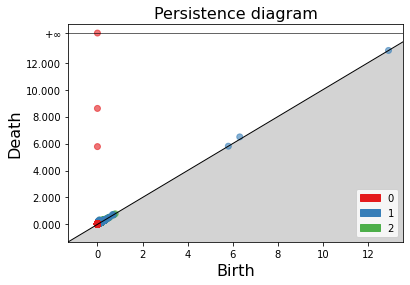

In [38]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [39]:
dgm

[(2, (0.0983772315502558, 0.3179175348687407)),
 (2, (0.09904936992696789, 0.26427174345510235)),
 (2, (0.11543042028167769, 0.2587044967179486)),
 (2, (0.09975263189047706, 0.23948767510406216)),
 (2, (0.10264614882758961, 0.24189317023463083)),
 (2, (0.09432293857615526, 0.2327900558977689)),
 (2, (0.1077143655643242, 0.24449563992860074)),
 (2, (0.12321957923065015, 0.259440469714071)),
 (2, (0.10901924978683719, 0.24450132662446994)),
 (2, (0.10203568898708422, 0.23699329651273948)),
 (2, (0.12000568397528129, 0.2513895224214674)),
 (2, (0.2571806437683319, 0.36417701350986503)),
 (2, (0.1256786114209655, 0.23262157495427244)),
 (2, (0.24687986849057095, 0.35234970401761717)),
 (2, (0.1507052945284369, 0.251604381301042)),
 (2, (0.14045731256929295, 0.23643195830324892)),
 (2, (0.1497540989150506, 0.24273638760615157)),
 (2, (0.16474878124746511, 0.2561382139725479)),
 (2, (0.21120162128427392, 0.30124450649778595)),
 (2, (0.1923326225050242, 0.28236924083920617)),
 (2, (0.16881310

In [40]:
eps=.05
countClusts=len([i[1][1] for i in dgm if i[0]==0 and i[1][1]>eps])
countClusts

3

In [ ]:
dat=p0Gro.xyz[10,:] #time 10 -- cyllindrical component
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

In [ ]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

# Over a given polymer distribution
- track time dep for given alpha (eg, .05)


In [ ]:
p0Gro.xyz[0].shape

In [ ]:
def dgmGrabP0(comptemp,maxH=2,thresh=0,roundDig=5,saveDir=None,retDgms=False): #assume 3D for now
    groFile=load(f"{comptemp[0]}/{comptemp[0]}_{comptemp[1]}.gro")#comptemp=(comp,temp)
    p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
    p0Gro=groFile.restrict_atoms(p0Index)
    
    #dat=p0Gro.xyz[0,:] #time 0
    timedgms={t:dict() for t in range(len(p0Gro.xyz))}
    t=-1
    for dat in p0Gro.xyz:
        t+=1
        ac = gudhi.AlphaComplex(dat)
        st = ac.create_simplex_tree()
        dgm=st.persistence()
        dgms={b:[] for b in range(maxH+1)}
        if thresh!=0:
            for i in dgm:
                lifetime=round(i[1][1]-i[1][0],roundDig)
                if lifetime>=thresh:
                    dgms[i[0]].append(i[1])
        else:
            for i in dgm:
                dgms[i[0]].append(i[1])
        timedgms[t]=dgms
    
    ### timedgms will need to be converted back to {b:[(),...]} -> [(b0,()),(b0,()),...]
    ### to plot using gudhi
    
    if saveDir and type(saveDir)==str:
        f=open(saveDir,"w")
        json.dump(timedgms,f)
    elif saveDir !=0:
        saveDir=f"Z:/data/micelles/topDat/{comptemp[0]}_{comptemp[1]}_t{t+1}PH.json"
        f=open(saveDir,"w")
        json.dump(timedgms,f)
        f.close()
    if retDgms:
        return timedgms
            
        
 

In [ ]:
def dgmGrabGro(gro,maxH=2,thresh=0,roundDig=5,saveDir=None,retDgms=False): #assume 3D for now
    #dat=p0Gro.xyz[0,:] #time 0
    timedgms={t:dict() for t in range(len(gro.xyz))}
    t=-1
    for dat in gro.xyz:
        t+=1
        ac = gudhi.AlphaComplex(dat)
        st = ac.create_simplex_tree()
        dgm=st.persistence()
        dgms={b:[] for b in range(maxH+1)}
        if thresh!=0:
            for i in dgm:
                lifetime=round(i[1][1]-i[1][0],roundDig)
                if lifetime>=thresh:
                    dgms[i[0]].append(i[1])
        else:
            for i in dgm:
                dgms[i[0]].append(i[1])
        timedgms[t]=dgms
    
    ### timedgms will need to be converted back to {b:[(),...]} -> [(b0,()),(b0,()),...]
    ### to plot using gudhi
    
    if saveDir and type(saveDir)==str:
        f=open(saveDir+f"_t{t+1}PH.json","w")
        json.dump(timedgms,f)
    elif saveDir !=0:
        saveDir=f"Z:/data/micelles/topDat/{comptemp[0]}_{comptemp[1]}_t{t+1}PH.json"
        f=open(saveDir,"w")
        json.dump(timedgms,f)
        f.close()
    if retDgms:
        return timedgms
            
        
 

In [ ]:
polyComp=['L64', 'P104', 'P123', 'P65', 'P84', 'P85']

In [ ]:
#Load a testdat
comp=polyComp[0]
temp=temps[0]


dgmGrabP0((comp,temp),thresh=.05)

In [ ]:
inDir="Z:/data/micelles"
try:
    os.mkdir(f"{inDir}/topDat_eps05/")
except:
    pass

for comp in polyComp:
    try:
        os.mkdir(f"{inDir}/topDat_eps05/{comp}")
    except:
        pass


for comp in polyComp:
    for temp in temps:
        #dgmGrabP0((comp,temp),thresh=.05)
        outDir=f"{comp}/{comp}_{temp}"
        groFile=load(f"{inDir}/Micelles_identification/{outDir}.gro")
        p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
        groFile=groFile.restrict_atoms(p0Index)

        dgmGrabGro(groFile,thresh=0.05,saveDir=f"{inDir}/topDat_eps05/{outDir}")
        
        groFile=load(f"{inDir}/Micelles_identification/{comp}/{comp}_ini_{temp}.gro")
        p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
        groFile=groFile.restrict_atoms(p0Index)
        dgmGrabGro(groFile,thresh=0.05,saveDir=f"{inDir}/topDat_eps05/{comp}/{comp}_ini_{temp}")

In [ ]:
for comp in ['High_conc']:
    try:
        os.mkdir(f"{inDir}/topDat_eps05/{comp}")
        os.mkdir(f"{inDir}/topDat_eps05/{comp}/P103")
    except:
        pass

groFile=mdtraj.load(f"{inDir}/Micelles_identification/High_conc/P103/P103_25.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
groFile=groFile.restrict_atoms(p0Index)
dgmGrabGro(groFile,thresh=.05,saveDir=f"{inDir}/topDat_eps05/High_conc/P103/P103_HC_25")
groFile=mdtraj.load(f"{inDir}/Micelles_identification/High_conc/P103/P103_35.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
groFile=groFile.restrict_atoms(p0Index)
dgmGrabGro(groFile,thresh=.05,saveDir=f"{inDir}/topDat_eps05/High_conc/P103/P103_HC_35")

# Dynamics of Simplicial Complex

In [41]:
res=[1200,1200]
def genTimeCluster(groFile,alpha=.05,saveName=None,cam=dict(eye=dict(x=.75, y=2, z=.25)),titPref="",clustCount=True,dt=1): #assume 3D for now
    if len(groFile.xyz.shape)==3:
        t=0
        for dat in groFile.xyz:
            ac = gudhi.AlphaComplex(dat)
            st = ac.create_simplex_tree()
            skel=list(st.get_skeleton(2))
            skel.sort(key=lambda s: s[1])
            points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
            lims=[[np.floor(np.min(dat[:,i])),np.ceil(np.max(dat[:,i]))] for i in range(3)]
            
            sfig=[
                    go.Scatter3d(
                        x = points[:, 0],
                        y = points[:, 1],
                        z = points[:, 2],
                        mode='markers',
                        marker=dict(
                            size=1,
                            color="cornflowerblue",                # set color to an array/list of desired values
                            #colorscale='Viridis',   # choose a colorscale
                            opacity=.9
                        ),
                        name='H0'
                        )
            ]
            
            b1s=np.array([s[0] for s in skel if len(s[0]) == 2 and s[1] <= alpha])

            linepts={0:[],1:[],2:[]}
            for i in b1s:
                linepts[0].append(points[i[0],0])
                linepts[1].append(points[i[0],1])
                linepts[2].append(points[i[0],2])
                linepts[0].append(points[i[1],0])
                linepts[1].append(points[i[1],1])
                linepts[2].append(points[i[1],2])

                linepts[0].append(None)
                linepts[1].append(None)
                linepts[2].append(None)

            if len(linepts[0])>0:
                lins=go.Scatter3d(
                    x=linepts[0],
                    y=linepts[1],
                    z=linepts[2],
                    mode='lines',
                    name='H1',
                    marker=dict(
                        size=3,
                        color="#d55e00",                # set color to an array/list of desired values
                        #colorscale='Viridis',   # choose a colorscale
                        opacity=.85
                    )
                )
                sfig.append(lins)
                triangles = np.array([s[0] for s in skel if len(s[0]) == 3 and s[1] <= alpha])
                if len(triangles)>0:
                    mesh = go.Mesh3d(
                        x = points[:, 0],
                        y = points[:, 1],
                        z = points[:, 2],
                        i = triangles[:, 0],
                        j = triangles[:, 1],
                        k = triangles[:, 2],
                        color="#009e73",
                        opacity=.75,
                        name='H2'
                    )
                    sfig.append(mesh)
            tit=f"{titPref}       :       Simplicial complex with radius <= {round(float(alpha),5)}       \t\t\tFrame:  {t*dt} ns"
            if clustCount:
                dgm=st.persistence()
                clustCount=len([i[1][1] for i in dgm if i[0]==0 and i[1][1]>alpha])
                tit+=f"       :       Cluster Count  =  {clustCount}"
            fig=go.Figure(data=sfig,layout=go.Layout(width=res[0],height=res[1],
                                                     title=tit,
                                                     scene_camera=cam
                                                    ))
            if type(saveName)==str:
                fig.write_json(file=saveName+f"t{t}.json",engine="auto")
                fig.write_image(file=saveName+f"t{t}.png")
            t+=1
    else:
        print("err in .xyz grab on input")
        return

In [ ]:
comp=polyComp[-1]
temp=temps[1]
groFile=load(f"{polyComp[-1]}/{polyComp[-1]}_{temps[1]}.gro")#comptemp=(comp,temp)
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)

alp=.05
saveDir=r"C:\code\git\topML\frames\\"

try:
    os.mkdir(saveDir+f"{comp}_{temp}")
except:
    pass

saveName=saveDir+"/"+f"{comp}_{temp}/{comp}_{temp}_{alp}"


In [ ]:

genTimeCluster(p0Gro,saveName=saveName)

In [ ]:
osout=os.system(f"ffmpeg -r 5 -f image2 -s 1000x1000 -i /mnt/c/code/git/topML/frames/P85_20_0.05t%d.png -vcodec libx264 -crf 18 /mnt/c/code/git/topML/frames/test2.mp4")

In [ ]:
osout

In [ ]:
groFile=mdtraj.load(f"High_conc/P103/P103_25.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)

saveDir=r"C:\code\git\topML\frames\\"
try:
    os.mkdir(saveDir+f"High_conc")
except:
    pass

alp=.05
saveName=saveDir+"/High_conc/"+f"P103_25_{alp}"
genTimeCluster(p0Gro,alpha=alp,saveName=saveName)

In [ ]:
os.system(f"ffmpeg -r 5 -f image2 -s 1000x1000 -i /mnt/c/code/git/topML/frames/High_conc/P103_25_0.05t%d.png -vcodec libx264 -crf 18 /mnt/c/code/git/topML/frames/High_conc/P103_25_a05.mp4")

In [ ]:

groFile=mdtraj.load(f"P85/P85_ini_20.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)

#saveDir=r"C:\code\git\topML\frames\\"
saveName=f"/mnt/c/code/git/topML/frames/"
try:
    os.mkdir(saveDir+f"init")
except:
    pass

alp=.05
saveName=saveDir+"/init/"+f"P85_ini_20_{alp}"
genTimeCluster(p0Gro,alpha=alp,saveName=saveName)

In [ ]:
os.system(f"ffmpeg -r 5 -f image2 -s 1000x1000 -i /mnt/c/code/git/topML/frames/init/P85_ini_20_0.05t%d.png -vcodec libx264 -crf 18 /mnt/c/code/git/topML/frames/init/P85_ini_20_a05.mp4")

In [46]:
groName="P85_ini_20"
titPref=f"{groName[:-3]} @ {groName[-2:]}" + " \u00B0 C" # title prefix
groFile=mdtraj.load(f"{groName[:groName.find('_')]}/{groName}.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)

#saveDir=r"C:\code\git\topML\frames\\"
saveDir=f"/mnt/c/code/git/topML/frames/"
try:
    os.mkdir(saveDir+f"init")
except:
    pass


dt=4 #4 ns between frame I believe 
alp=.05
saveName=saveDir+"/init/"+f"{groName}_{alp}"
counter=True
genTimeCluster(p0Gro,alpha=alp,saveName=saveName,titPref=titPref,dt=dt,clustCount=counter)

In [24]:
print("\u00B0")

°


In [17]:
def saveMov(saveNameBase,res,fps,outName,tryRm=True, delFileCheck = lambda f: f.find(".png")!=-1 or f.find(".jpg")!=-1 or f.find(".json")!=-1):
    osout=os.system(f"ffmpeg -r {fps} -f image2 -s {res[0]}x{res[1]} -i {saveNameBase}t%d.png -vcodec libx264 -crf 18 {outName}.mp4")
    if osout==0 and tryRm:
        rootDir=saveNameBase[:-1* saveNameBase[::-1].find("/")]
        for f in os.listdir(rootDir):
            if delFileCheck(f):
                try:
                    os.remove(f"{rootDir}{f}")
                except:
                    print(f"del error! \t {rootDir}{f}\n\n")
                    break

In [47]:
saveName=f"/mnt/c/code/git/topML/frames/init/P85_ini_20_{alp}"
fps=5
tryRm=True
res=[1200,1200]
outName=f"/mnt/c/code/git/topML/frames/{groName}_{alp}"
saveMov(saveName,res,fps,outName,tryRm=tryRm)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [48]:
for groName in ["P123_ini_20","P123_ini_40","P85_ini_40","P85_ini_20"]:
    titPref=f"{groName[:-3]} @ {groName[-2:]}" + " \u00B0 C"
    groFile=mdtraj.load(f"{groName[:groName.find('_')]}/{groName}.gro")
    p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
    p0Gro=groFile.restrict_atoms(p0Index)

    #saveDir=r"C:\code\git\topML\frames\\"
    saveDir=f"/mnt/c/code/git/topML/frames/"


    dt=10 #10 ns between frame I believe 
    alp=.05
    saveName=saveDir+"/init/"+f"{groName}_{alp}"
    counter=True
    genTimeCluster(p0Gro,alpha=alp,saveName=saveName,titPref=titPref,dt=dt,clustCount=counter)
    
    
    fps=5
    tryRm=True
    res=[1200,1200]
    outName=f"/mnt/c/code/git/topML/frames/{groName}_{alp}"
    saveMov(saveName,res,fps,outName,tryRm=tryRm)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
#finally just save the persistence diagrams from these bois to show in the paper